In [14]:
# Load required packages
import torch
from torch import nn
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = False
import numpy as np

# register acceleration devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load Benchmark Data

out = np.load('training-val-test-data.npz')
th_data = out['th'] #th[0],th[1],th[2],th[3],...
u_data = out['u'] #u[0],u[1],u[2],u[3],...

from sklearn import model_selection
u_train, u_val, y_train, y_val= model_selection.train_test_split(u_data, th_data, shuffle=False, test_size=0.3,random_state=42)
# Standardization
u_mean, u_std = np.mean(u_train),np.std(u_train)
y_mean, y_std = np.mean(y_train),np.std(y_train)


### Data to train and validate on ###:
u_train = (u_train-u_mean)/u_std #normalize
y_train = (y_train-y_mean)/y_std

u_val = (u_val-u_mean)/u_std
y_val = (y_val-y_mean)/y_std


def make_OE_data(udata, ydata, nf=100):
    U = []
    Y = []
    for k in range(nf,len(udata)+1):
        U.append(udata[k-nf:k]) #a)
        Y.append(ydata[k-nf:k]) #a)
    return np.array(U), np.array(Y)

nfuture = 30
convert = lambda x: [torch.tensor(xi,dtype=torch.float64,device=device) for xi in x]
Utrain, Ytrain = convert(make_OE_data(u_train, y_train, nf=nfuture))
Uval,   Yval   = convert(make_OE_data(u_val,   y_val,   nf=len(u_val))) #uses the whole data set for OE

cuda


In [15]:
# Code from EX3
class simple_RNN(nn.Module):
    def __init__(self, hidden_size):
        super(simple_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in,n_out: nn.Sequential(nn.Linear(n_in,40), \
                                               nn.Tanh(), \
                                               nn.Linear(40,n_out)).double() #new short hand
        self.h2h = net(self.input_size + hidden_size, self.hidden_size) #b=)
        self.h2o = net(self.input_size + hidden_size, self.output_size) #b=)
                                                                        #[:,0] should be called after use of h2o

    def forward(self, inputs):
        #input.shape == (N_batch, N_time)
        hidden = torch.zeros(inputs.shape[0], self.hidden_size, dtype=torch.float64, device=device) #c)
        outputs = [] #c)
        for i in range(inputs.shape[1]): #c)
            u = inputs[:,i] #shape = (N_batch,) #c)
            combined = torch.cat((hidden, u[:,None]), dim=1) #c) #shape = (N_batch,hidden_size+1)
            outputs.append(self.h2o(combined)[:,0]) #c)
            hidden = self.h2h(combined) #c)
        return torch.stack(outputs,dim=1) #c)

n_burn = 10
batch_size = 64

model = simple_RNN(hidden_size=15) #d=)
#model = nn.DataParallel(model) # Wrap the model with DataParallel
model = model.to(device=device) # Move the model to the GPU
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #d=)


ids = np.arange(len(Utrain),dtype=int)
for epoch in range(50):
    np.random.shuffle(ids) #inspace shuffle of the ids of the training set to select a random subset
    for i in range(0,len(Utrain),batch_size):
        ids_now = ids[i:i+batch_size] #the ids of the current batch
        Uin = Utrain[ids_now] #d)
        Y_real = Ytrain[ids_now] #d)
        model.train()
        Y_predict = model.forward(inputs=Uin) #d)
        residual = Y_real - Y_predict #d)
        Loss = torch.mean(residual[:,n_burn:]**2) #d)

        optimizer.zero_grad()  #d)
        Loss.backward()  #d)
        optimizer.step()  #d)

    with torch.no_grad(): #monitor
        model.eval()
        Loss_val = torch.mean((model(inputs=Uval)[:,n_burn:] - Yval[:,n_burn:])**2)**0.5
        Loss_train = torch.mean((model(inputs=Utrain)[:,n_burn:] - Ytrain[:,n_burn:])**2)**0.5
        print(f'epoch={epoch}, Validation NRMS={Loss_val.item():.2%}, Train NRMS={Loss_train.item():.2%}')

epoch=0, Validation NRMS=87.89%, Train NRMS=80.52%
epoch=1, Validation NRMS=60.75%, Train NRMS=66.33%


KeyboardInterrupt: 

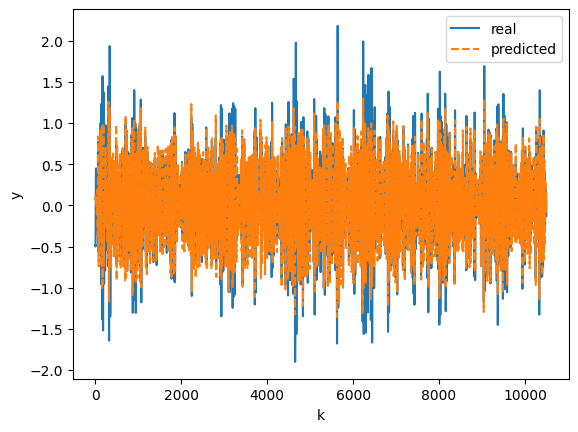

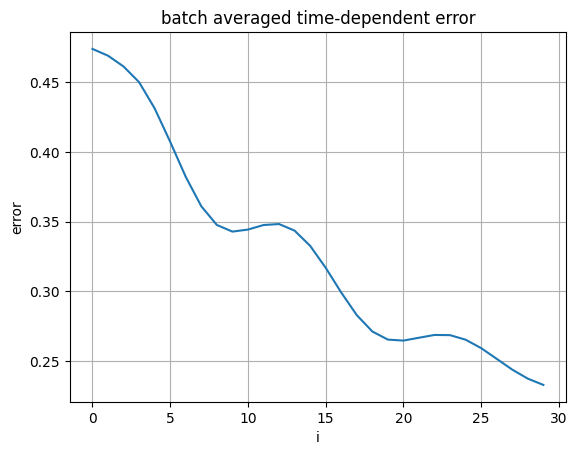

In [ ]:
with torch.no_grad():
    plt.plot((Yval[0]*y_std + y_mean).cpu())
    model.eval()
    plt.plot((model(inputs=Uval)[0] * y_std + y_mean).cpu(),'--')
    plt.xlabel('k')
    plt.ylabel('y')
    #plt.xlim(0,250)
    plt.legend(['real','predicted'])
    plt.show()
    model.eval()
    plt.plot(np.mean(((Ytrain-model(inputs=Utrain))*y_std).cpu().numpy()**2,axis=0)**0.5) #average over the error in batch
    plt.title('batch averaged time-dependent error')
    plt.ylabel('error')
    plt.xlabel('i')
    plt.grid()
    plt.show()

In [23]:
# LSTM from Exercise
def make_OE_data(udata,ydata,nf=100):
    U = [] #[u[k-nf],...,u[k]]
    Y = [] #[y[k-nf],...,y[k]]
    for k in range(nf,len(udata)+1):
        U.append(udata[k-nf:k])
        Y.append(ydata[k-nf:k])
    return np.array(U),np.array(Y)

nfuture = 100
convert = lambda x: [torch.tensor(xi,dtype=torch.float64, device=device) for xi in x]
Utrain,Ytrain = convert(make_OE_data(u_train,y_train,nf=nfuture))
Uval,Yval = convert(make_OE_data(u_val,y_val,nf=len(u_val)))

class simple_lstm(nn.Module):
    def __init__(self, hidden_size):
        super(simple_lstm, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in,n_out: nn.Sequential(nn.Linear(n_in,40),nn.Sigmoid(),nn.Linear(40,n_out)) #short hand for a 1 hidden layer NN
        self.lstm = nn.RNN(input_size=self.input_size,  hidden_size=hidden_size,  batch_first=True).double() #i)
        self.h2o = net(hidden_size + self.input_size, self.output_size).double() #i)

    def forward(self, inputs):
        #hiddens, (h_n, c_n) = self.lstm(inputs[:,:,None]) #i)
        hiddens, h_n = self.lstm(inputs[:,:,None]) #i)
        combined = torch.cat((hiddens,inputs[:,:,None]),dim=2) #i)
        if False: #two ways to solve this #i)
            y_predict = [] #i)
            for i in range(combined.shape[1]):  #i)
                y_predict.append(self.h2o(combined[:,i,:])[:,0])  #i)
            y_predict = torch.stack(y_predict,dim=1)  #i)
        else: #this is faster but more complex #i)
            #reshape from (N_batch, N_time, N_hidden) to (N_batch*N_time, N_hidden) #i)
            h2o_input = combined.view(-1,self.hidden_size+self.input_size) #i)
            #apply and reshape from (N_batch*N_time,1) to (N_batch,N_time) #i)
            y_predict =  self.h2o(h2o_input).view(inputs.shape[0],inputs.shape[1])  #new #i)

        return y_predict

n_burn = 20
model = simple_lstm(hidden_size=30)
#model = nn.DataParallel(model) # Wrap the model with DataParallel
model = model.to(device=device) # Move the model to the GPU
optimizer = torch.optim.Adam(model.parameters())
batch_size = 64

for epoch in range(10**3):
    for i in range(0,len(Utrain),batch_size):
        Uin = Utrain[i:i+batch_size]
        Yout = model.forward(inputs=Uin)
        Yin = Ytrain[i:i+batch_size]
        Loss = torch.mean((Yin[:,n_burn:] - Yout[:,n_burn:])**2)
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()

    with torch.no_grad():
        Loss_val = torch.mean((model(inputs=Uval)[:,n_burn:] - Yval[:,n_burn:])**2)**0.5
        Loss_train = torch.mean((model(inputs=Utrain)[:,n_burn:] - Ytrain[:,n_burn:])**2)**0.5
        print(f'epoch={epoch}, Validation Loss={Loss_val.item():.2%}, Train Loss={Loss_train.item():.2%}, Validation Loss absolute={Loss_val.item() * y_std}')

epoch=0, Validation Loss=64.11%, Train Loss=57.59%, Validation Loss absolute=0.2999386110674476
epoch=1, Validation Loss=51.92%, Train Loss=46.73%, Validation Loss absolute=0.24291746258115002
epoch=2, Validation Loss=48.02%, Train Loss=43.82%, Validation Loss absolute=0.22468258382900536
epoch=3, Validation Loss=39.37%, Train Loss=38.23%, Validation Loss absolute=0.18417265729869625
epoch=4, Validation Loss=37.98%, Train Loss=38.17%, Validation Loss absolute=0.17771262020657386
epoch=5, Validation Loss=37.33%, Train Loss=38.28%, Validation Loss absolute=0.1746450067203398
epoch=6, Validation Loss=36.97%, Train Loss=38.33%, Validation Loss absolute=0.17295072590792143
epoch=7, Validation Loss=36.90%, Train Loss=38.12%, Validation Loss absolute=0.17265690191439095
epoch=8, Validation Loss=37.18%, Train Loss=38.21%, Validation Loss absolute=0.17393604213100416
epoch=9, Validation Loss=37.68%, Train Loss=38.75%, Validation Loss absolute=0.17627762911859765
epoch=10, Validation Loss=39.20%

KeyboardInterrupt: 

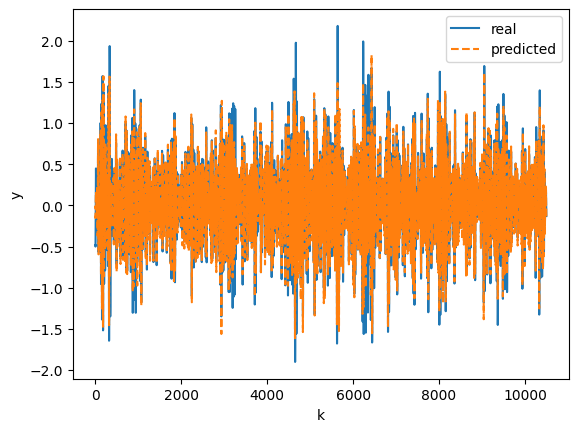

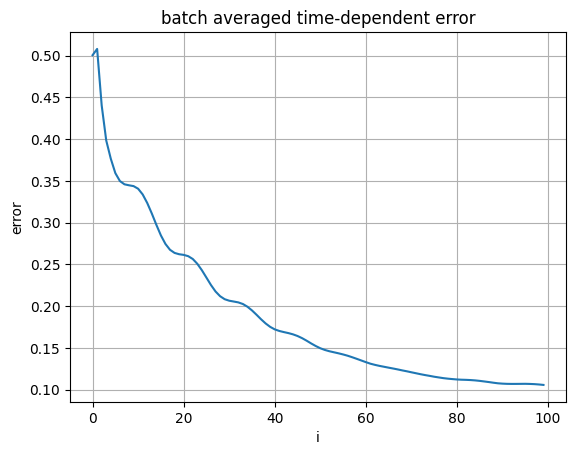

In [24]:
with torch.no_grad():
    plt.plot((Yval[0]*y_std + y_mean).cpu())
    model.eval()
    plt.plot((model(inputs=Uval)[0] * y_std + y_mean).cpu(),'--')
    plt.xlabel('k')
    plt.ylabel('y')
    #plt.xlim(0,250)
    plt.legend(['real','predicted'])
    plt.show()
    model.eval()
    plt.plot(np.mean(((Ytrain-model(inputs=Utrain))*y_std).cpu().numpy()**2,axis=0)**0.5) #average over the error in batch
    plt.title('batch averaged time-dependent error')
    plt.ylabel('error')
    plt.xlabel('i')
    plt.grid()
    plt.show()